In [112]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
sns.set(color_codes=True) # Set style and color of graphs

train = pd.read_csv("/Users/houzhuo/Downloads/housetrain.csv")
test    = pd.read_csv("/Users/houzhuo/Downloads/housetest.csv")
#full = train.append(test,ignore_index=True)
print ('Datasets:' , 'train:' , train.shape )
train.info()

('Datasets:', 'train:', (1460, 81))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-nul

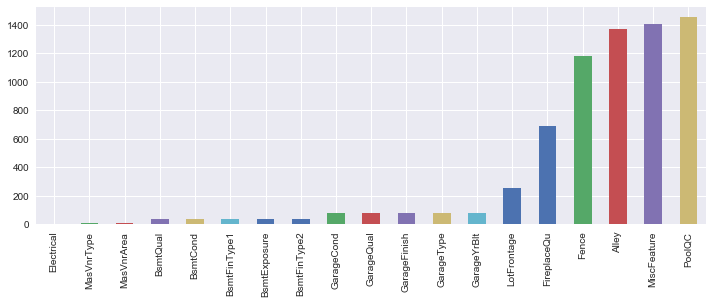

In [61]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16634fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1053d6d0>]], dtype=object)

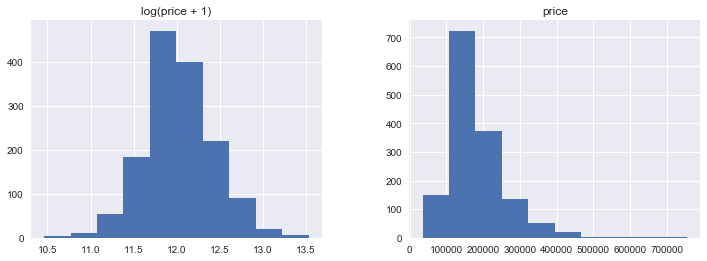

In [62]:
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

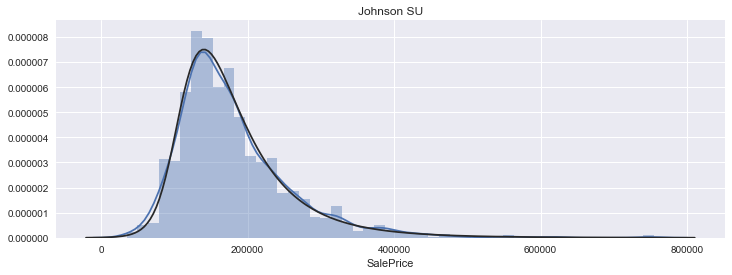

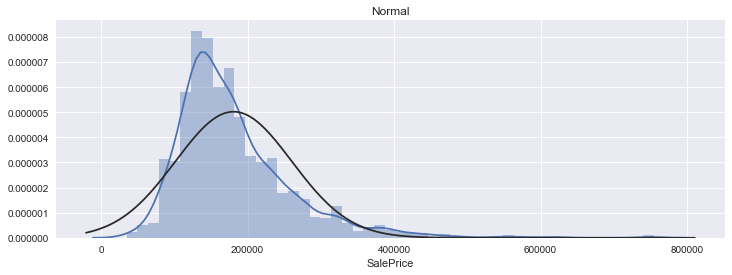

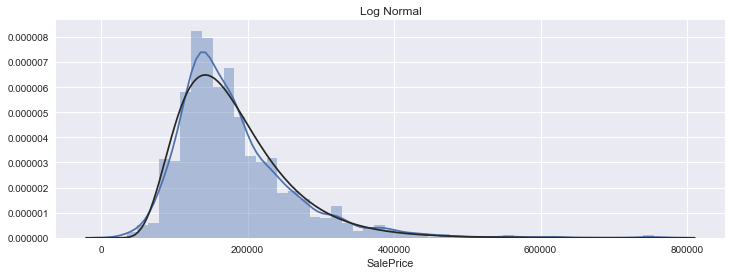

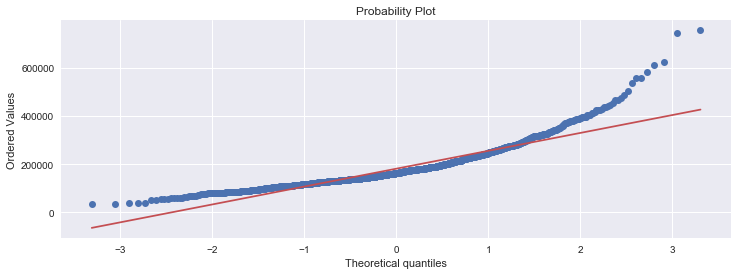

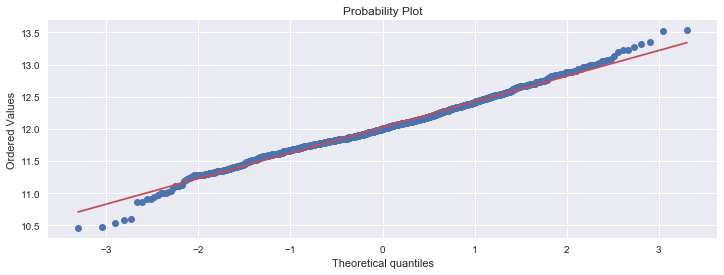

In [63]:
import scipy.stats as st
x = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(x, kde=True, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(x, kde=True, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(x, kde=True,hist=True, fit=st.lognorm)

#lognorm match the Johnson
#Get also the QQ-plot
from scipy import stats
fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()

fig = plt.figure()
res = st.probplot(np.log1p(train['SalePrice']), plot=plt)
plt.show()


In [88]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

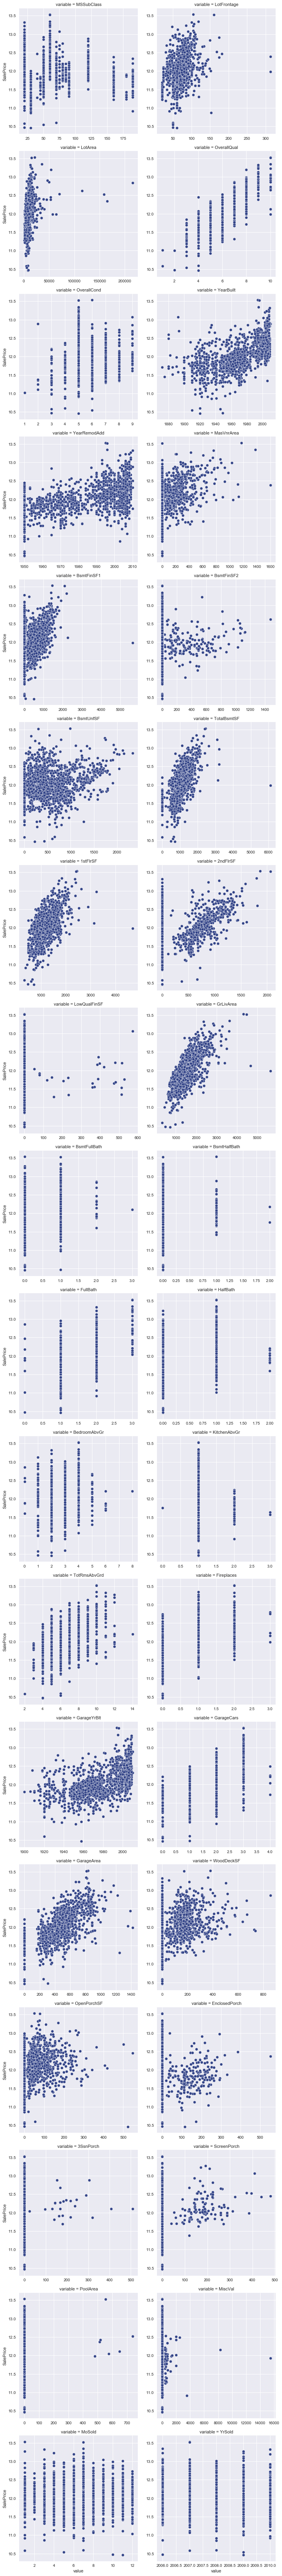

In [66]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative)
def distplot(x, y, **kwargs):
    sns.distplot(x=x, y=y, color='b')
    x=plt.xticks(rotation=90)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(plt.scatter, "value","SalePrice",color="#334488", edgecolor="white", lw=.5)

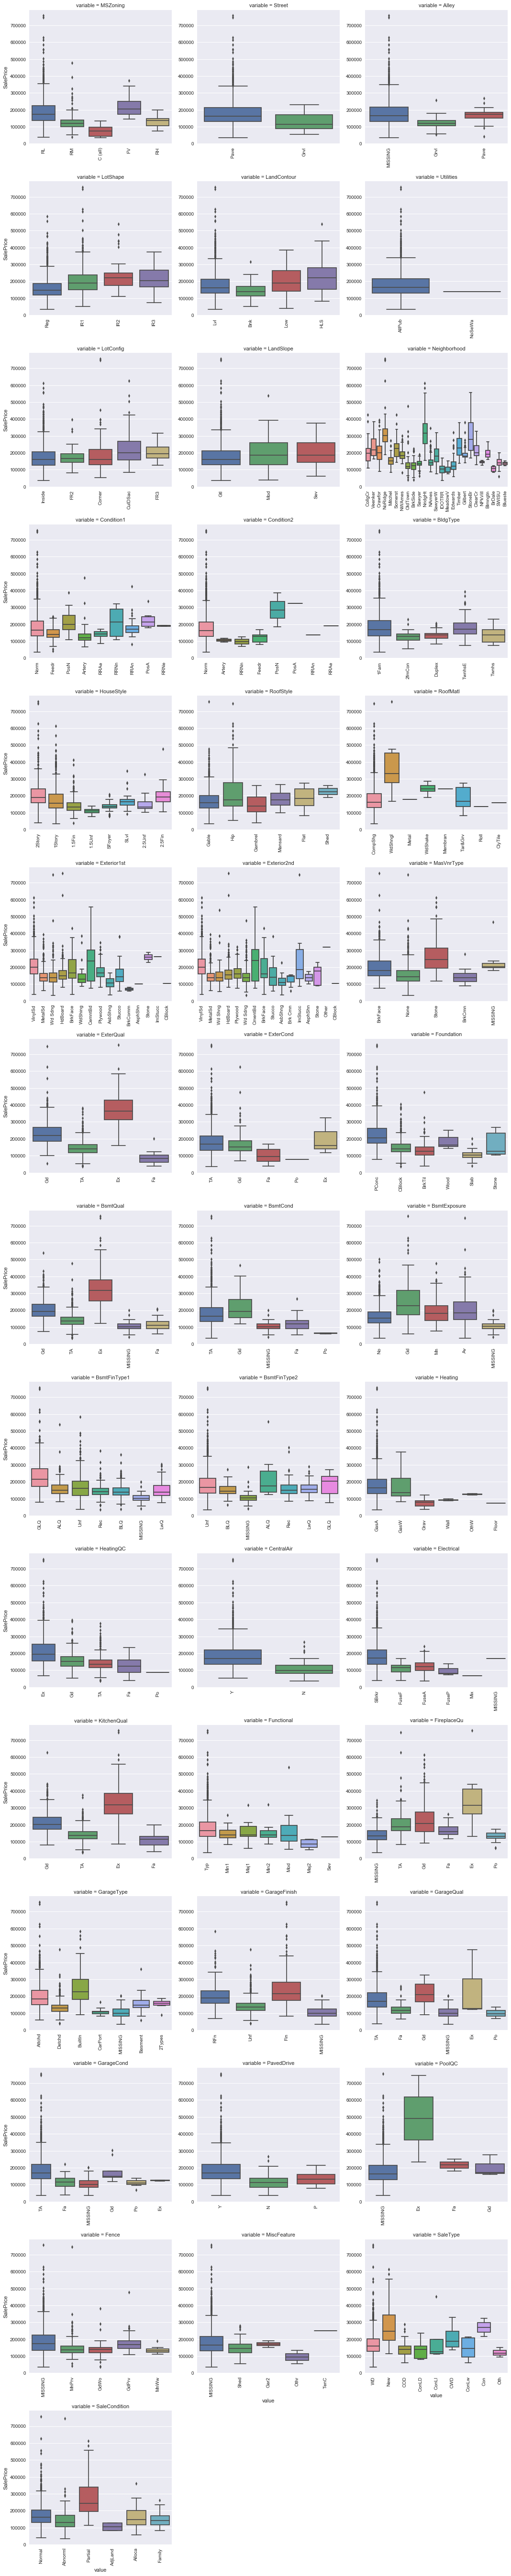

In [101]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

data delete before size is : (1460, 81)


(1458, 81)

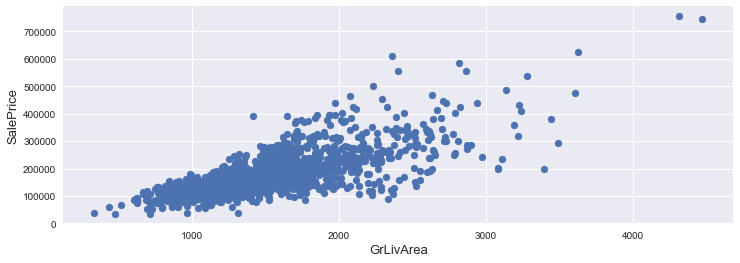

In [113]:
print("data delete before size is : {}".format(train.shape))
train.shape
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
#fig, ax = plt.subplots()
#ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
#plt.show()
plt.scatter(x="GrLivArea", y="SalePrice", data=train);
train.shape


 mu = 12.02 and sigma = 0.40



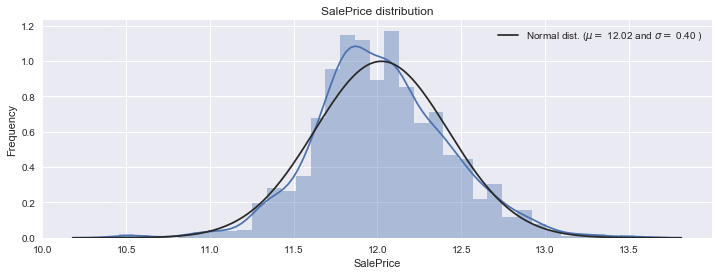

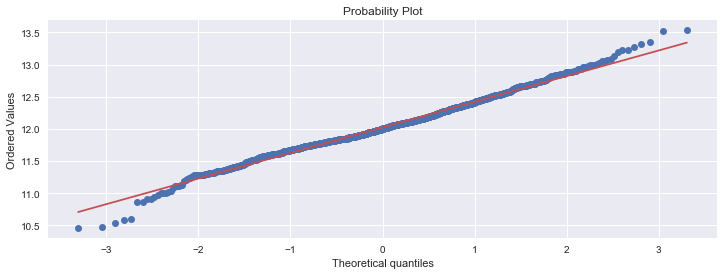

In [114]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()

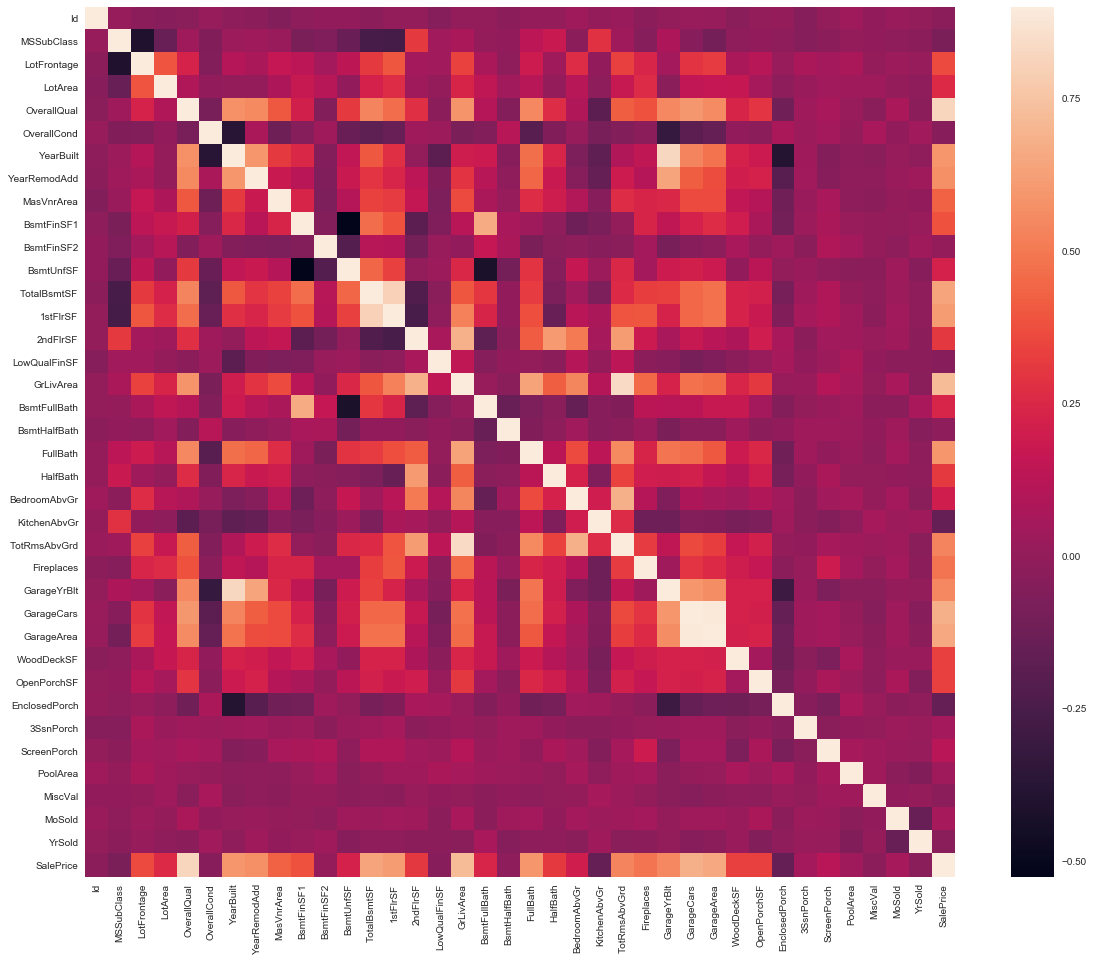

In [103]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(20,16))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [115]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
full = pd.concat((train, test)).reset_index(drop=True)
full.drop('Id', axis=1, inplace=True)
full.drop('SalePrice', axis=1, inplace=True)
print("all_data size is : {}".format(full.shape))


all_data size is : (2917, 79)


In [111]:
full['MSZoning'].mode()
full['Functional'].value_counts()

all_data size is : (2917, 80)


In [116]:
full["PoolQC"] = full["PoolQC"].fillna("None")
full["MiscFeature"] = full["MiscFeature"].fillna("None")
full["Alley"] = full["Alley"].fillna("None")
full["Fence"] = full["Fence"].fillna("None")
full["FireplaceQu"] = full["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
full["LotFrontage"] = full.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    full[col] = full[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    full[col] = full[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    full[col] = full[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    full[col] = full[col].fillna('None')
#NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
full["MasVnrType"] = full["MasVnrType"].fillna("None")
full["MasVnrArea"] = full["MasVnrArea"].fillna(0)
#Identifies the general zoning classification of the sale.
full['MSZoning'] = full['MSZoning'].fillna(full['MSZoning'].mode()[0])
full = full.drop('Utilities', axis=1)
full["Functional"] = full["Functional"].fillna("Typ")
#Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value
full['Electrical'] = full['Electrical'].fillna(full['Electrical'].mode()[0])

full['KitchenQual'] = full['KitchenQual'].fillna(full['KitchenQual'].mode()[0])


#Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
full['Exterior1st'] = full['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
full['Exterior2nd'] = full['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])

full['SaleType'] = full['SaleType'].fillna(full['SaleType'].mode()[0])

full['MSSubClass'] = full['MSSubClass'].fillna("None")

In [ ]:
missing = full.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [ ]:
full['Fence'].astype

In [118]:
#MSSubClass=The building class
full['MSSubClass'] = full['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
full['OverallCond'] = full['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
full['YrSold'] = full['YrSold'].astype(str)
full['MoSold'] = full['MoSold'].astype(str)

In [ ]:
full['OverallCond']

In [119]:
#Label Encoding some categorical variables that may contain information in their ordering set

le = LabelEncoder()
    
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    le = LabelEncoder() 
    le.fit(full[c]) 
    full[c] = le.transform(full[c])

# shape        
print('Shape all_data: {}'.format(full.shape))

Shape all_data: (2917, 78)


In [120]:
# Adding total sqfootage feature 
full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']

In [121]:
from scipy.stats import norm, skew #for some statistics

numeric_feats = full.dtypes[full.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = full[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [122]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    full[feat] = boxcox1p(full[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [123]:
full = pd.get_dummies(full)
print(full.shape)

(2917, 220)


In [124]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
X_train = full[:ntrain]
X_test = full[ntrain:]

In [125]:
X_train

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.692623,11.686189,0.000000,0.730463,1.540963,1.820334,1.540963,11.170327,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1
1,12.792276,0.000000,0.000000,0.730463,1.540963,1.820334,0.730463,12.062832,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
2,11.892039,11.724598,0.000000,0.730463,1.540963,1.820334,1.194318,10.200343,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1
3,12.013683,11.354094,0.000000,0.730463,1.540963,0.730463,1.540963,8.274266,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
4,12.510588,12.271365,0.000000,0.730463,1.820334,1.820334,0.000000,10.971129,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1
5,11.493820,10.589574,9.178051,0.730463,0.730463,1.820334,1.540963,11.267217,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1
6,13.670207,0.000000,0.000000,0.730463,1.540963,1.820334,0.000000,13.031093,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1
7,12.413831,12.077149,0.000000,0.730463,1.540963,1.820334,1.194318,11.702249,4.597157,0.000000,...,0,0,0,0,0,0,0,0,0,1
8,12.186751,11.339779,0.000000,0.730463,1.194318,1.820334,1.540963,0.000000,0.000000,2.259674,...,0,0,0,0,0,0,0,0,0,1
9,12.335431,0.000000,0.000000,0.730463,1.194318,1.820334,1.540963,11.676516,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1


In [126]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn import model_selection

In [209]:
rf = RandomForestRegressor(n_estimators=190, 
                           max_features= 'sqrt',verbose= 0 )
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
gbm = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [201]:

n_folds = 5
#def rmsle_cv(model):
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
score= np.sqrt(-cross_val_score(rf, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (score.mean(), score.std(), label))

Accuracy: 0.1390 (+/- 0.0073) [lasso]


In [210]:
print('5-fold cross validation:\n')
stack = StackingCVRegressor(regressors=(xgb,ENet, KRR, gbm, lgb,), 
                          meta_regressor=ENet)
for clf, label in zip([xgb, ENet, KRR, gbm, lgb, stack], 
                      ['XGBRegressor', 
                       'ENet', 
                       'KRR',
                       'gbm',
                       'lgb',
                       'lasso']):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    scores = np.sqrt(-model_selection.cross_val_score(clf, X_train.values, y_train, 
                                              cv=kf,scoring='neg_mean_squared_error'))
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.1157 (+/- 0.0063) [XGBRegressor]
Accuracy: 0.1116 (+/- 0.0074) [ENet]
Accuracy: 0.1153 (+/- 0.0075) [KRR]
Accuracy: 0.1177 (+/- 0.0080) [gbm]
Accuracy: 0.1162 (+/- 0.0071) [lgb]
Accuracy: 0.1086 (+/- 0.0069) [lasso]


In [151]:

#Validation function
n_folds = 5
#def rmsle_cv(model):
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
score= np.sqrt(-cross_val_score(lasso, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#return(rmse)
#score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [177]:
sclf.fit(X_train,y_train)

StackingClassifier(average_probas=False,
          classifiers=[Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, ra...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)],
          meta_classifier=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1.7817,
       missing=None, n_estimators=2200, n_jobs=1, nthread=-1,
       objective='reg:linear', random_state=7, reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.5213),
          store_train_meta_features=False, use_features_in_secondary=False,
          use_probas=False

In [211]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
stack.fit(X_train.values, y_train)
#sclf_pred = sclf.predict(X_train.values)
stack_train_pred = stack.predict(X_train.values)
stack_pred = np.expm1(stack.predict(X_test.values))
print(rmsle(y_train, stack_train_pred))

#stacked_averaged_models.fit(train.values, y_train)
##stacked_train_pred = stacked_averaged_models.predict(train.values)
#stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
#print(rmsle(y_train, stacked_train_pred))

0.0715157990149


In [141]:
sclf_pred

array([ 121922.515625 ,  169643.9375   ,  182704.375    , ...,
        162154.375    ,  115391.7109375,  216730.625    ], dtype=float32)

In [212]:
#y_test = sclf.predict( X_test )

Id = test.Id
test = pd.DataFrame( { 'Id': Id , 'SalePrice': stack_pred.astype(np.int64) } )
#test.shape
#test.head()
test.to_csv( 'house_pred.csv' , index = False )